## Time series forecasting with Multivariate-DeepAR - GolfData with all weather data

Author: Yiran Jing

Date: 29-07-2019

**Main motivation**:
When dataset contains hundreds of feature time series, the DeepAR+ recipe outperforms the standard ARIMA and ETS 
methods. 

This notebook shows the whole workflow to create JSON data for training, deploying and forecast basic DeepAR+models within SageMaker notebook.

**Tunning DeepAR model** will be separate to another notebook.

### Advantages of DeepAR+ sagemaker:
1. User-Defined window length (train/test dataset), rather than default values 
2. User can set hyperparameter for DeepAR+ algo 
3. User can also calculate any kinds of Predictor Metrics, rather than P10, P50(MAPE),P90 only. 

**DataSet Description** 

Golf data (one-dimentional time series data set with three column) 
- **Item_id**: string, region
- **Target_value**: float, amount
- **timestamp**: timestamp, month

Weather data: Rainfall (Five-dimentional time series data set with three column) 
- **Item_id**: string, region
- **High**: float, high
- **Low**: float, low
- **Rainfall**: float, rainfall
- **Snowfall**: float, snowfall
- **Daylight_hours**: float, daylight_hours
- **timestamp**: timestamp, month


In [1]:
import boto3
import pandas as pd
import pyspark
from sagemaker import get_execution_role
import seaborn as sns
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, skew
import statsmodels.api as sm
blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import nltk
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime

##### Load Data

In [2]:
#golf_data = 's3://taysols-data/GolfDataforecast/nonstationary_amount_region.csv'
golf_data = pd.read_csv('nonstationary_amount_region.csv',encoding = "ISO-8859-1",names=['month','amount','region'])
#golf_data = pd.read_csv(golf_data, encoding = "ISO-8859-1", header=None)
golf_data.shape

(579, 3)

In [3]:
golf_data.head(3)

,month,amount,region
0,2010-01-01,1165742.039,Australia
1,2010-01-01,2478456.728,Southwest
2,2010-01-01,5827990.362,Southeast


In [7]:
all_weather = 's3://taysolsdev/datasets/GolfDataforecast/nonstationary_all.csv'
all_weather = pd.read_csv(all_weather, encoding = "ISO-8859-1", names=['month',"high","low","rainfall","snowfall","daylight_hours",'region'])

In [8]:
all_weather.head(3)

,month,high,low,rainfall,snowfall,daylight_hours,region
0,2010-01-01,2,-11,11,178,10,Midwest
1,2010-01-01,0,-6,49,192,10,Illinois
2,2010-01-01,0,-7,57,290,10,Canada


##### Left Join two datasets based on regin

In [10]:
golf_data = pd.merge(golf_data, all_weather,how='left')


#### Fill missing value
Some recoreds donot have weather information
if Nan, fill to 0. 
The input data cannot have missing value in dynamic_feat array

In [11]:
golf_data['rainfall'] = golf_data['rainfall'].fillna(0)
golf_data['high'] = golf_data['high'].fillna(0)
golf_data['low'] = golf_data['low'].fillna(0)
golf_data['snowfall'] = golf_data['snowfall'].fillna(0)
golf_data['daylight_hours'] = golf_data['daylight_hours'].fillna(0)

In [12]:
golf_data.head(5)

,month,amount,region,high,low,rainfall,snowfall,daylight_hours
0,2010-01-01,1165742.039,Australia,26.000,19.000,118.000,0.000,14.000
1,2010-01-01,2478456.728,Southwest,20.000,10.000,85.000,0.000,10.000
2,2010-01-01,5827990.362,Southeast,22.000,11.000,60.000,0.000,11.000
3,2010-01-01,55775.918,South Korea,1.000,-7.000,23.000,0.000,10.000
4,2010-01-01,497842.220,SA,0.000,0.000,0.000,0.000,0.000


In [13]:
golf_data.shape

(579, 8)

## Step 1: Data formatting: Input/Output Interface for the DeepAR Algorithm
DeepAR supports two types of data files: JSON Lines (one JSON object per line) and Parquet. 

In this case, I comvert dataset to **JSON LINES** format. http://jsonlines.org/ 

##### WHY JSON Lines:
1. **Better than CSV**: CSV has no standard encoding, no standard column separator and multiple character escaping standards. By contrast, JSON Lines handles tabular data cleanly and without ambiguity. Cells may use the standard JSON types.
2. **Easy Nested Data**. JSON Lines' biggest strength is in handling lots of similar nested data structures. 

##### Three requirements for JSON Lines:
1. UTF-8 Encoding
2. Each Line is a Valid JSON Value
3. Line Separator is '\n'

##### The records in your input files should contain the following fields: 
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
1. **start** — A string with the format YYYY-MM-DD HH:MM:SS.
2. **target** — An array of floating-point values or integers that represent the time series. You can encode missing values as null literals, or as "NaN" strings in JSON.
3. **dynamic_feat**(optional) — An array of arrays of floating-point values or integers that represents the vector of custom feature time series (dynamic features). If you set this field, all records must have the same number of inner arrays (the same number of feature time series). In addition, each inner array must have the same length as the associated target value. Missing values are not supported in the features. 
  - **Continuous time-series**: For example, in our case, weather data.
  - **boolean time-series**: For example, if target time series represents the demand of different products, an associated dynamic_feat might be a boolean time-series which indicates whether a promotion was applied (1) to the particular product or not (0). Another example is special_day_features.
4. **cat**(optional) — categories: If your time series belong to different groups (e.g. types of product, regions, etc), this information can be encoded as one or more categorical features using the cat field. An array of categorical features that can be used to encode the groups that the record belongs to. Categorical features must be encoded as a 0-based sequence of positive integers. For example, the categorical domain {R, G, B} can be encoded as {0, 1, 2}.

Example:
$$\{"start": ..., "target": [1, 5, 10, 2], "dynamic\_feat": [[0, 1, 1, 0]]\}$$
$$\{"start": "2009-11-01 00:00:00", "target": [4.3, "NaN", 5.1, ...], "cat": [0, 1], "dynamic\_feat": [[1.1, 1.2, 0.5, ...]]\}$$

Since our data contain 36 regions, so the value of cat is from 0 to 35. And since some region has less than two years data, so some 'NaN' values in the end of 'target' array:
$$Australia: \{"start": "2010-01-01 00:00:00", "target": [, , , ...], "cat": [0], "dynamic\_feat": [[23...]]\}$$ 
$$Oregon: \{"start": "2010-01-01 00:00:00", "target": ["NaN","NaN","NaN","NaN", , , ...], "cat": [[1]], "dynamic\_feat": [23...]\}$$  
$$Japan: \{"start": "2010-01-01 00:00:00", "target": [, , , ...], "cat": [35], "dynamic\_feat": [[23...]]\}$$

In [14]:
np.random.seed(1)
import json
import s3fs
import sagemaker
from sagemaker import get_execution_role

The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the get_execution_role function to obtain the role arn which was specified when creating the notebook.

In [29]:
# The S3 bucket and prefix that you want to use for training and model data. 
bucket = 'taysolsdev'
prefix = 'datasets/GolfDataforecast/MultivariateDeepAR/Golf_all_weatherdata'

In [30]:
s3_data_path = "{}/{}".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [31]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [32]:
##  Get the DeepAR container so we can run the DeepAR model
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Set main hyperparameters
1. time_freq: frequency of the time series used. The time series that we use have monthly granularity.
2. context_length: number of data points the model will look at in the past. A typical value to start with is around the same size as the prediction_length. 
3. prediction_length: number of  predicted data points. 

**Rule for length decision**
$$Average length > context\_length + prediction\_length$$
In our case, Average length is 10

In [33]:
freq = 'M'
prediction_length = 3 # 3 month.

In [34]:
context_length = 6 # 6 month

In [35]:
regions = golf_data.iloc[:,2].unique()
regions

array(['Australia', 'Southwest', 'Southeast', 'South Korea', 'SA',
       'Other NA', 'Other Asia', 'Northeast', 'West', 'Midwest',
       'Middle East', 'Mexico', 'Japan', 'Europe', 'Canada', 'None',
       'Other Midwest', 'Ohio', 'Other Northeast', 'Oregon',
       'Other Southeast', 'Texas', 'Other West', 'South Carolina',
       'Other Southwest', 'California', 'New Mexico', 'Arizona',
       'Connecticut', 'Florida', 'Georgia', 'New York', 'Michigan',
       'Nevada', 'New Jersey', 'Illinois'], dtype=object)

In [42]:
num_ts = 36 # we have 36 regions 
time_series = []

# collect the weather information for each region
dynamic_feat_high = {} 
dynamic_feat_low = {}
dynamic_feat_rainfall = {}
dynamic_feat_snowfall = {}
dynamic_feat_daylight_hours = {}

region_num = {} # save the region and its correspoinding number
for k in range(num_ts):
    source = golf_data[golf_data.iloc[:,2] == regions[k]] 
    source.index = pd.DatetimeIndex(start = source.iloc[0,0], periods = len(source.iloc[:,0]), freq = 'M')
    #print(source.head())
    region_num[regions[k]]= k
    dynamic_feat_high[k] = source.iloc[:,3]
    dynamic_feat_low[k] = source.iloc[:,4]
    dynamic_feat_rainfall[k] = source.iloc[:,5]
    dynamic_feat_snowfall[k] = source.iloc[:,6]
    dynamic_feat_daylight_hours[k] = source.iloc[:,7]
    data = source.iloc[:,1] # only select amount
    time_series.append(pd.Series(data=data))

In [43]:
region_num

{'Australia': 0,
 'Southwest': 1,
 'Southeast': 2,
 'South Korea': 3,
 'SA': 4,
 'Other NA': 5,
 'Other Asia': 6,
 'Northeast': 7,
 'West': 8,
 'Midwest': 9,
 'Middle East': 10,
 'Mexico': 11,
 'Japan': 12,
 'Europe': 13,
 'Canada': 14,
 'None': 15,
 'Other Midwest': 16,
 'Ohio': 17,
 'Other Northeast': 18,
 'Oregon': 19,
 'Other Southeast': 20,
 'Texas': 21,
 'Other West': 22,
 'South Carolina': 23,
 'Other Southwest': 24,
 'California': 25,
 'New Mexico': 26,
 'Arizona': 27,
 'Connecticut': 28,
 'Florida': 29,
 'Georgia': 30,
 'New York': 31,
 'Michigan': 32,
 'Nevada': 33,
 'New Jersey': 34,
 'Illinois': 35}

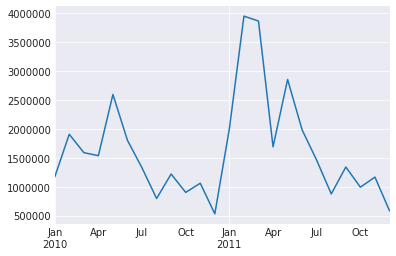

In [44]:
time_series[0].plot() # australia
plt.show()

#### Create training dataset

In [46]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])
    
dynamic_feat_high_training = {}
for key in dynamic_feat_high:
    dynamic_feat_high_training[key] = dynamic_feat_high[key][:-prediction_length]

dynamic_feat_low_training = {}
for key in dynamic_feat_low:
    dynamic_feat_low_training[key] = dynamic_feat_low[key][:-prediction_length]

dynamic_feat_rainfall_training = {}
for key in dynamic_feat_rainfall:
    dynamic_feat_rainfall_training[key] = dynamic_feat_rainfall[key][:-prediction_length]
    
dynamic_feat_snowfall_training = {}
for key in dynamic_feat_snowfall:
    dynamic_feat_snowfall_training[key] = dynamic_feat_snowfall[key][:-prediction_length]
    
dynamic_feat_daylight_hours_training = {}
for key in dynamic_feat_daylight_hours:
    dynamic_feat_daylight_hours_training[key] = dynamic_feat_daylight_hours[key][:-prediction_length]


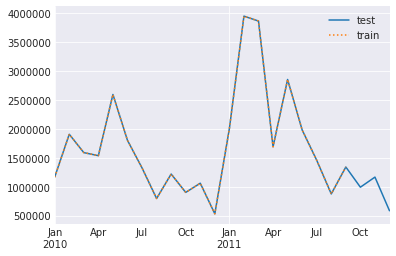

In [47]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

The following utility functions convert pandas.Series objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [48]:
def series_to_obj(ts, cat=None,dynamic_feat = None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    #print(str(ts.index[0]))
    #print(ts.index[0]+1)
    if cat is not None:
        obj["cat"] = cat
    
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    
    return obj

def series_to_jsonline(ts, cat=None,dynamic_feat = None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))

In [59]:
encoding = "utf-8"
#s3filesystem = s3fs.S3FileSystem()
count = 0
with open("train.json", 'wb') as f: # wb means write bytes
    for ts in time_series_training:
        cat = count
        dynamic_feat_region = []
        dynamic_feat_region.append(list(dynamic_feat_high_training[cat]))
        dynamic_feat_region.append(list(dynamic_feat_low_training[cat]))
        dynamic_feat_region.append(list(dynamic_feat_rainfall_training[cat]))
        dynamic_feat_region.append(list(dynamic_feat_snowfall_training[cat]))
        dynamic_feat_region.append(list(dynamic_feat_daylight_hours_training[cat]))
        
        
        #print(series_to_jsonline(ts,cat=cat, dynamic_feat=dynamic_feat_region))
        f.write(series_to_jsonline(ts,cat=cat, dynamic_feat=dynamic_feat_region).encode(encoding))
        f.write('\n'.encode(encoding))
        count +=1
count = 0        
with open("test.json", 'wb') as f: # wb means write bytes
    for ts in time_series:
        cat = count
        #print(series_to_jsonline(ts,cat=cat,dynamic_feat=dynamic_feat_region))
        dynamic_feat_region = []
        dynamic_feat_region.append(list(dynamic_feat_high[cat]))
        dynamic_feat_region.append(list(dynamic_feat_low[cat]))
        dynamic_feat_region.append(list(dynamic_feat_rainfall[cat]))
        dynamic_feat_region.append(list(dynamic_feat_snowfall[cat]))
        dynamic_feat_region.append(list(dynamic_feat_daylight_hours[cat]))
        
        f.write(series_to_jsonline(ts,cat=cat, dynamic_feat=dynamic_feat_region).encode(encoding))
        f.write('\n'.encode(encoding))
        count +=1
                
        

### Train DeepAR Model
1. recommend training a DeepAR model on as many time series as are available. Although a DeepAR model trained on a single time series might work well, standard forecasting algorithms, such as ARIMA or ETS, might provide more accurate results. The DeepAR algorithm starts to outperform the standard methods when your dataset contains hundreds of related time series.
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
2. **When tuning a DeepAR model**, you can split the dataset to create a training dataset and a test dataset. In a typical evaluation, you would test the model on the same time series used for training, but on the future prediction_length time points that follow immediately after the last time point visible during training. https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-tuning.html
3. Avoid using very large values (>400) for the prediction_length because it makes the model slow and less accurate. 
4. Because lags are used, a model can look further back in the time series than the value specified for context_length. Therefore, you don't need to set this parameter to a large value. We recommend starting with the value that you used for prediction_length.

We can now define the estimator that will launch the training job.

In [60]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='Sagemaker-DeepAR-Golf-all-weatherdata',
    output_path="s3://" + s3_output_path
)

### Set some hyperparameters
1. time_freq: frequency of the time series used
2. context_length: number of data points the model will look at in the past
3. prediction_length: number of  predicted data points. 

The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as number of epochs, batch size, and learning rate. Refer to the documentation for a full description of the available parameters.

In [61]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [62]:
estimator.set_hyperparameters(**hyperparameters)

### launch the training job
SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

Note: the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [63]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

2019-07-29 01:47:12 Starting - Starting the training job...
2019-07-29 01:47:13 Starting - Launching requested ML instances......
2019-07-29 01:48:13 Starting - Preparing the instances for training...
2019-07-29 01:49:09 Downloading - Downloading input data...
2019-07-29 01:49:17 Training - Downloading the training image..
Arguments: train
[07/29/2019 01:49:53 INFO 140434446964544] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/29/2019 01:49:53 


2019-07-29 01:50:09 Uploading - Uploading generated training model
2019-07-29 01:50:09 Completed - Training job completed
Billable seconds: 60


#### Create endpoint and predictor

In [64]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

--------------------------------------------------------------------------------------------------!

### Model Validation: Accuracy metrics based on test data

If you provide the test data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last prediction_length points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output. 

#### Fixed Window Forecast

In [65]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat = None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """
        Fixed Window Forecast
        
        Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts] 
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        #instances = [series_to_obj(ts[k], int(cat[k]) if cat else None) for k in range(len(ts))]
        instances = [series_to_obj(ts[k], int(cat[k]), dynamic_feat[k]) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [66]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)


### Make predictions and plot results

We will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

Since prediction only contain quantile 0.1, 0.9, 0.5, we use quantile 0.5 to calculate the MAPE.

Compared to the plot of univariate DeepAR model:
1. We can see significant forecast improvement here(such as Australia). But see the plots for other regions below: really bad forecast for some regions, such as Southwest
2. When we donot have weather information, it doesnot affect model performance.
3. Worse MAPE in multivariate model using rainfall weather information.

In [74]:
MAPES = []
for key in region_num:
    MAPE = {}
    i = int(region_num[key])
    #print(key)
    
    dynamic_feat_1 = []
    dynamic_feat_1.append(list(dynamic_feat_high[i]))
    dynamic_feat_1.append(list(dynamic_feat_low[i]))
    dynamic_feat_1.append(list(dynamic_feat_rainfall[i]))
    dynamic_feat_1.append(list(dynamic_feat_snowfall[i]))
    dynamic_feat_1.append(list(dynamic_feat_daylight_hours[i]))
    

    # DeepAR prediction
    list_of_df = predictor.predict(time_series_training[i:(i+1)],cat = str(i),dynamic_feat = [dynamic_feat_1]) # plot the first region Australia
    actual_data = time_series[i:(i+1)]
        
    # genterate origin data
    y_true = actual_data[0][-prediction_length:]
    
    y_pred = []
    y_pred = list_of_df[0]['0.5'] # predicted median
    
    # calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # add MAPE and region to list
    MAPE['region'] = key
    MAPE['MAPE'] = mape
    MAPES.append(MAPE)
    

In [75]:
MAPES = pd.DataFrame(MAPES)
"""
The average MAPE over all regions
"""
np.mean(MAPES['MAPE'])

53.481445978698204

In [76]:
# The MAPE for each region
MAPES

,MAPE,region
0,25.029,Australia
1,51.797,Southwest
2,30.240,Southeast
3,196.649,South Korea
4,51.732,SA
5,45.913,Other NA
6,48.603,Other Asia
7,24.021,Northeast
8,21.924,West
9,25.834,Midwest


In [ ]:
"""
plot the first region Australia
"""
# genterate origin data
origin_data = []
for k in range(len(time_series_training[0])):
    x = pd.Series(data = time_series_training[0][k], index= [time_series_training[0].index[k]])
    origin_data.append(x)

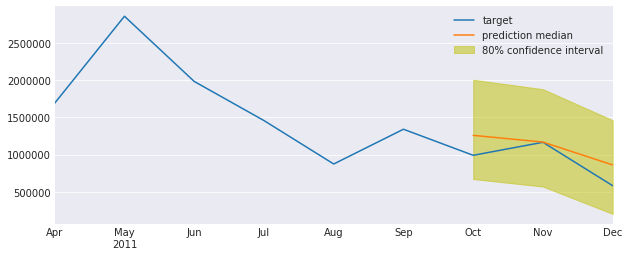

In [77]:
dynamic_feat_1 = []
dynamic_feat_1.append(list(dynamic_feat_high[0]))
dynamic_feat_1.append(list(dynamic_feat_low[0]))
dynamic_feat_1.append(list(dynamic_feat_rainfall[0]))
dynamic_feat_1.append(list(dynamic_feat_snowfall[0]))
dynamic_feat_1.append(list(dynamic_feat_daylight_hours[0]))

list_of_df = predictor.predict(time_series_training[0:1],cat = '0', 
                               dynamic_feat = [dynamic_feat_1]) # plot the first region Australia

actual_data = time_series[0:1]

for k in range(len(list_of_df)):
    plt.figure(figsize=(10,4))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

Australia


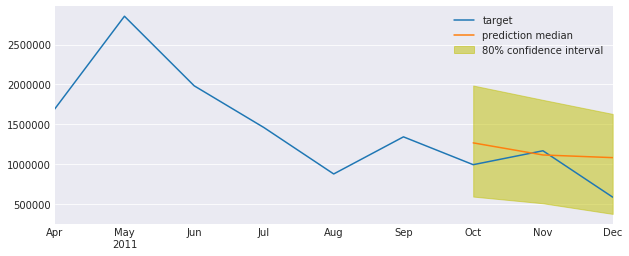

Southwest


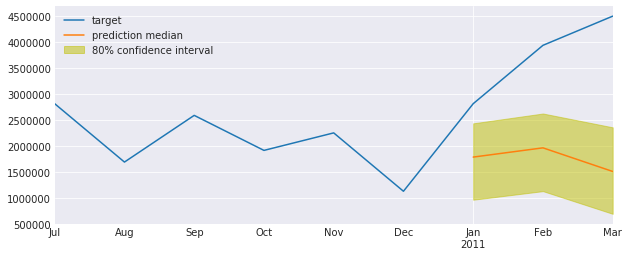

Southeast


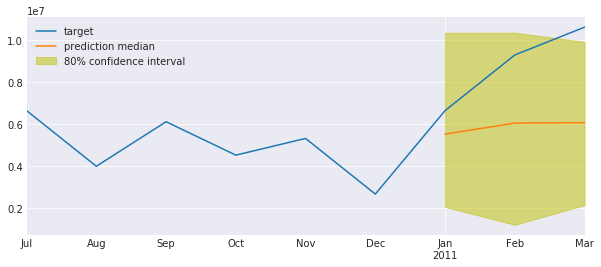

South Korea


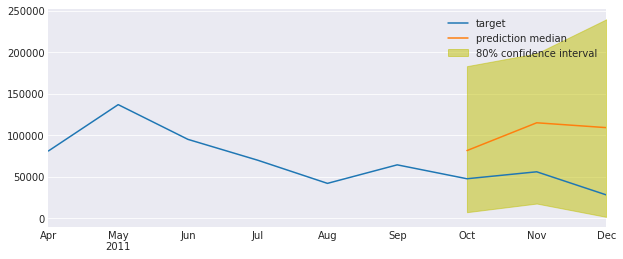

SA


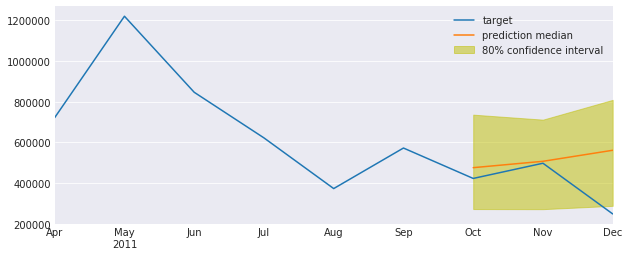

Other NA


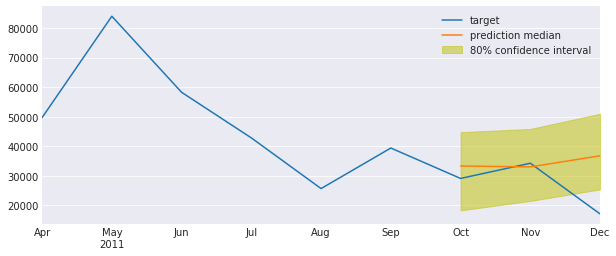

Other Asia


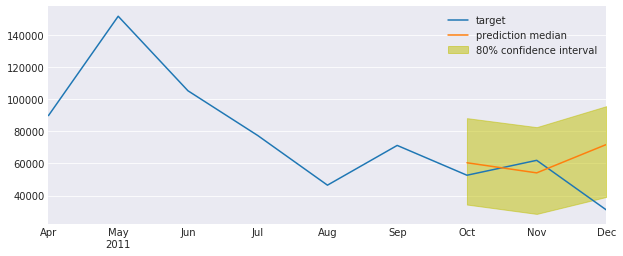

Northeast


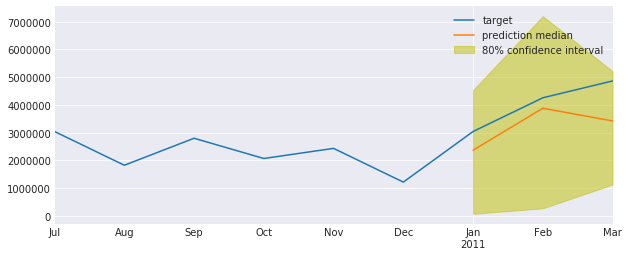

West


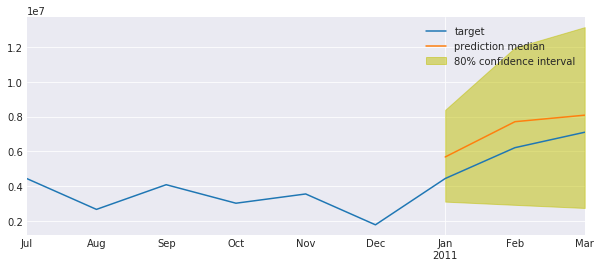

Midwest


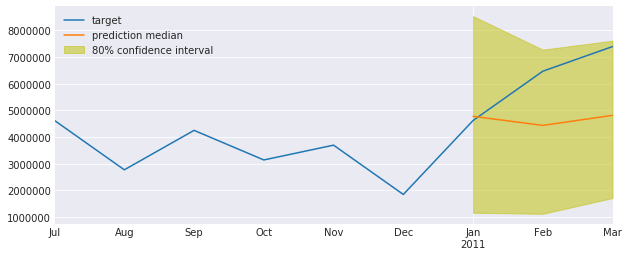

Middle East


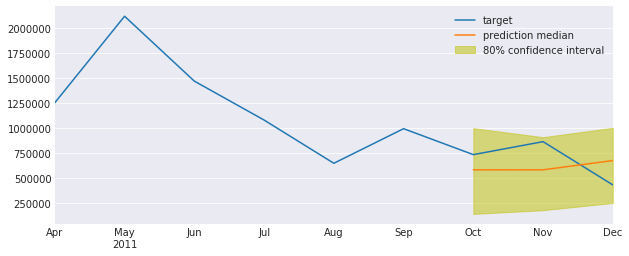

Mexico


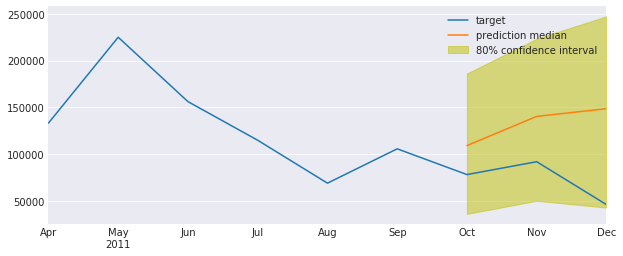

Japan


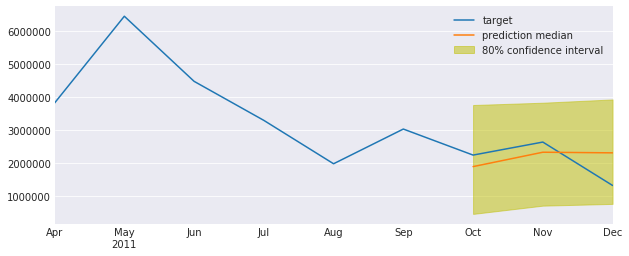

Europe


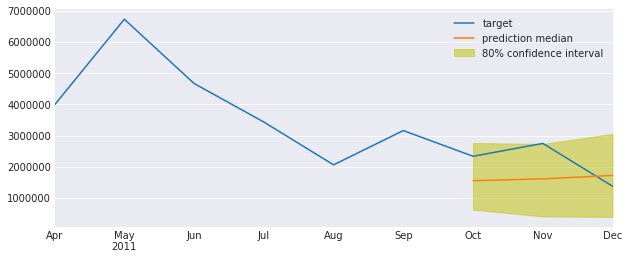

Canada


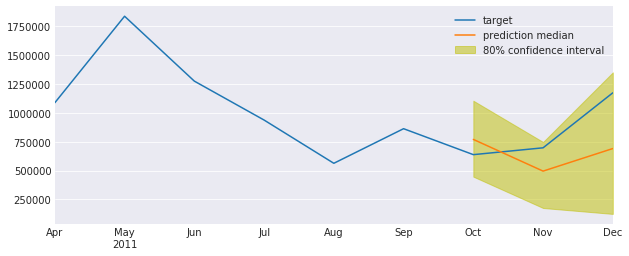

None


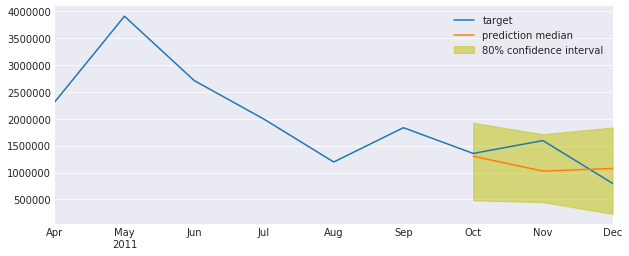

Other Midwest


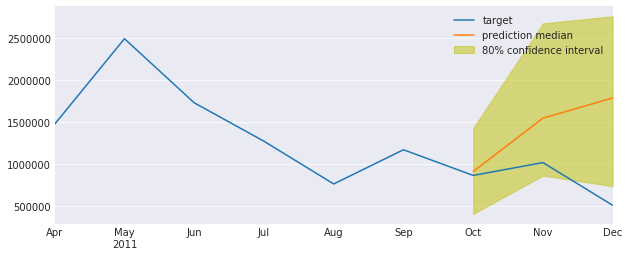

Ohio


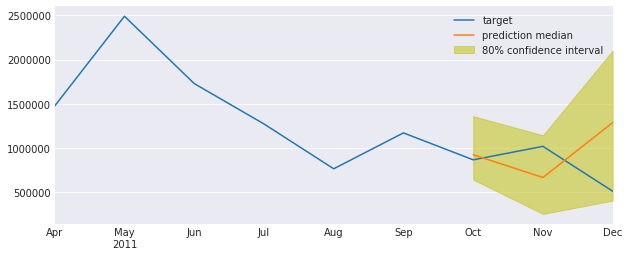

Other Northeast


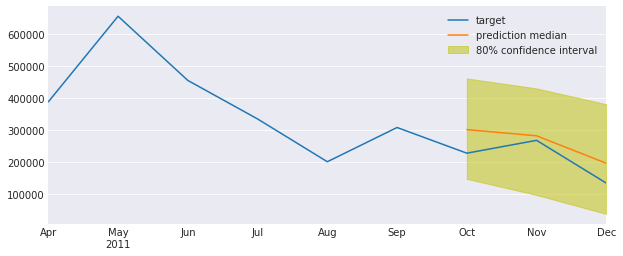

Oregon


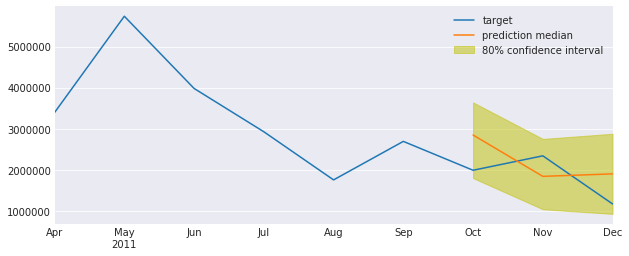

Other Southeast


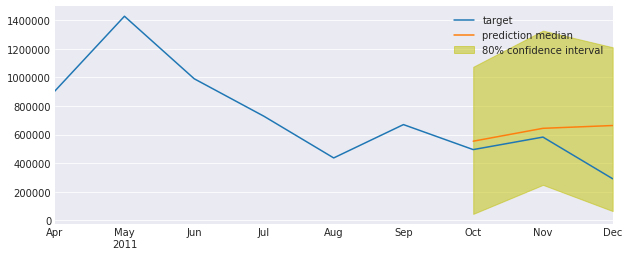

Texas


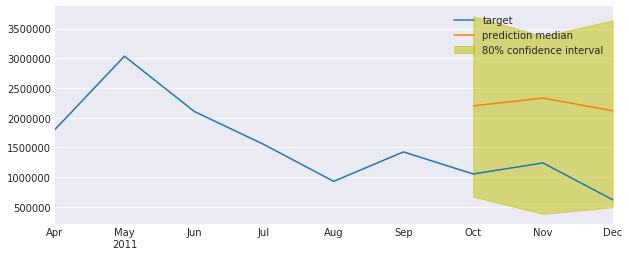

Other West


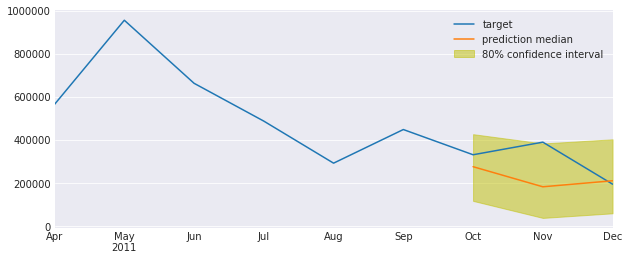

South Carolina


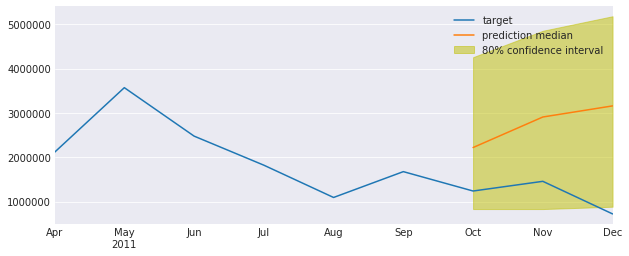

Other Southwest


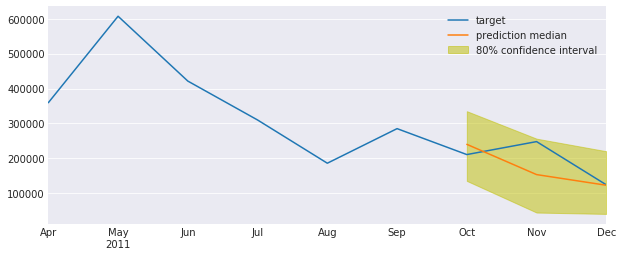

California


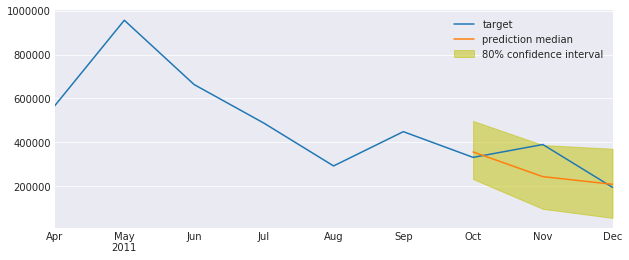

New Mexico


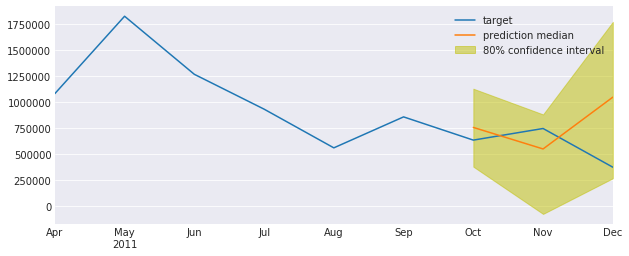

Arizona


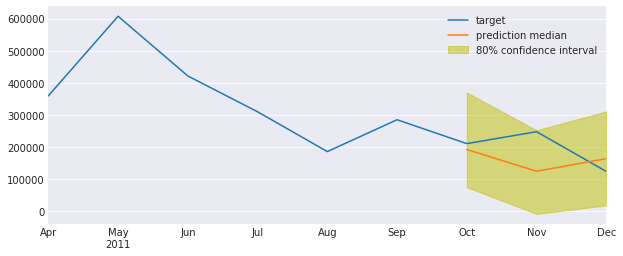

Connecticut


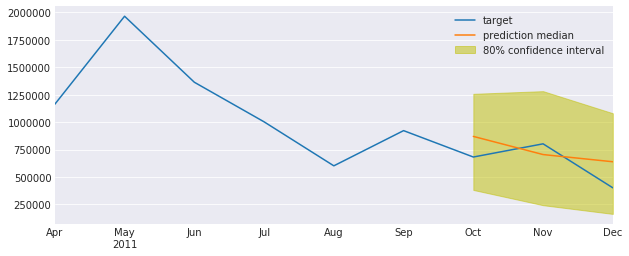

Florida


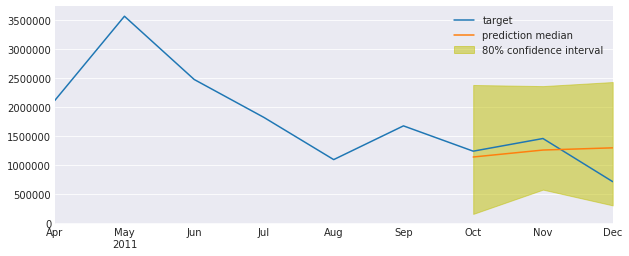

Georgia


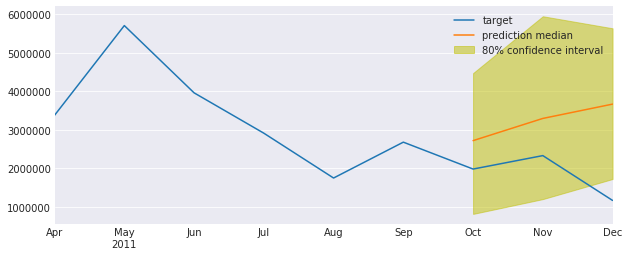

New York


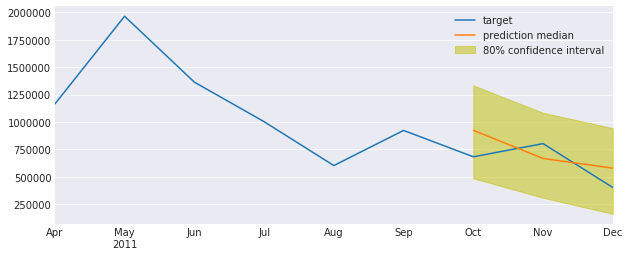

Michigan


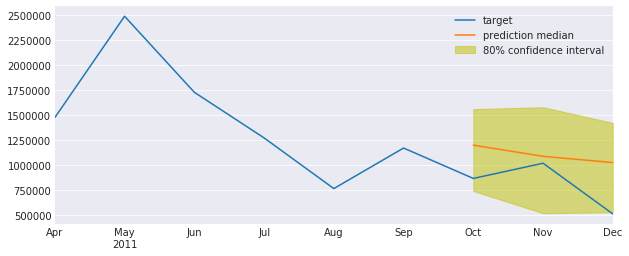

Nevada


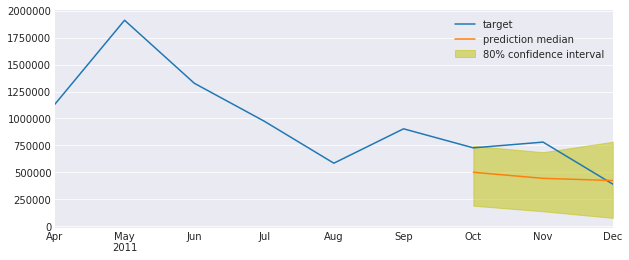

New Jersey


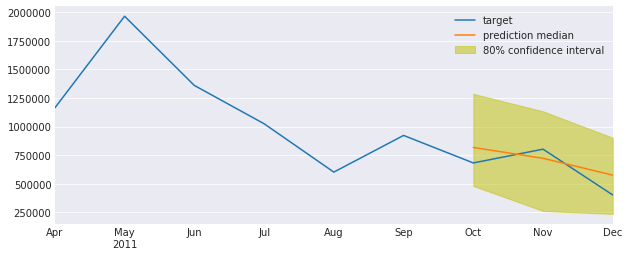

Illinois


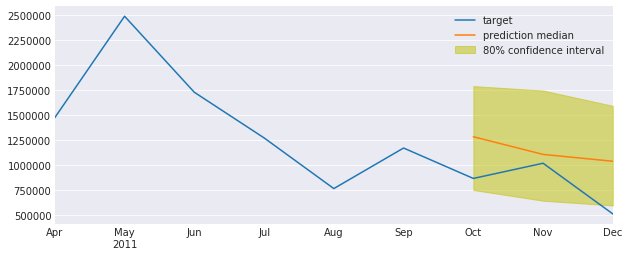

In [78]:
"""
plot All regions
"""
for key in region_num:
    i = int(region_num[key])
    print(key)
    
    # genterate origin data
    origin_data = []
    for k in range(len(time_series_training[i])):
        x = pd.Series(data = time_series_training[i][k], index= [time_series_training[i].index[k]])
        origin_data.append(x)
    
    # get the list for dynamic_feat 
    dynamic_feat_1 = []
    dynamic_feat_1.append(list(dynamic_feat_high[i]))
    dynamic_feat_1.append(list(dynamic_feat_low[i]))
    dynamic_feat_1.append(list(dynamic_feat_rainfall[i]))
    dynamic_feat_1.append(list(dynamic_feat_snowfall[i]))
    dynamic_feat_1.append(list(dynamic_feat_daylight_hours[i]))
   
    # DeepAR prediction
    list_of_df = predictor.predict(time_series_training[i:(i+1)],cat = str(i), dynamic_feat = [dynamic_feat_1]) # plot the first region Australia
    actual_data = time_series[i:(i+1)]
    
    # plot 
    for k in range(len(list_of_df)):
        plt.figure(figsize=(10,4))
        actual_data[k][-prediction_length-context_length:].plot(label='target')
        p10 = list_of_df[k]['0.1']
        p90 = list_of_df[k]['0.9']
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        list_of_df[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()